<a href="https://colab.research.google.com/github/RUCUAL/Machine-Learning/blob/main/Unidad02/SVR%20(Support%20Vector%20Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4. SVR (Support Vector Regression)
El SVR es un modelo que intenta encontrar el hiperplano que mejor se ajusta a los datos dentro
de un margen de error tolerado.
Parámetros Sugeridos para Exploración:
• kernel: El tipo de función kernel (ej., linear, rbf (por defecto), poly).
• C: Parámetro de penalización del error (cuanto más alto, más penaliza los errores).
Ejecución y Análisis:
1. Paso Preliminar (Obligatorio): Debido a que SVR es sensible a la escala, se DEBEN
escalar los datos (X) antes de entrenar el modelo (ej. usando StandardScaler o
MinMaxScaler).
2. Ejecución 1 (Kernel RBF): Usar el kernel por defecto (rbf) con las variables escaladas.
3. Ejecución 2 (Kernel Linear): Usar el kernel linear y comparar su (R2) con el resultado
de la Regresión Lineal Múltiple.

**CARGAR LIBRERIRAS Y DATOS**

**librerías necesarias**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)

**Cargar el dataset**

In [2]:
file_name = 'DATASET_Asesinatos.csv'
try:
    df = pd.read_csv(file_name, encoding='latin-1')
    print(f"Dataset '{file_name}' cargado exitosamente.")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{file_name}'. Asegúrate de subirlo a Colab.")

Dataset 'DATASET_Asesinatos.csv' cargado exitosamente.


**Inspección Inicial**

In [3]:
print("\n--- Inspección de Datos ---")
print(f"Dimensiones del Dataset (filas, columnas): {df.shape}")
print("\nPrimeras 5 filas:")
print(df.head())
print("\nInformación de tipos de datos y valores nulos:")
df.info()


--- Inspección de Datos ---
Dimensiones del Dataset (filas, columnas): (3000, 16)

Primeras 5 filas:
                Estado  id_area  habitantes  area_km2  ingresos_medios  \
0               Puebla        1      207953     26.70            48018   
1              Durango        2       80226     17.39            50295   
2              Tabasco        3      260806     70.69            50795   
3  Baja California Sur        4      969508    830.49            68910   
4       Aguascalientes        5       69478     30.59            54248   

   edad_media_poblacion  densidad_poblacional  indice_gini  \
0                  40.8               7787.47        0.522   
1                  42.4               4612.66        0.346   
2                  39.5               3689.22        0.417   
3                  27.3               1167.39        0.399   
4                  36.2               2271.26        0.422   

   tasa_desempleo_juvenil  porcentaje_sin_diploma_secundaria  \
0               

**Verificación de Variables Clave**

In [4]:
target_variable = 'tasa_asesinatos_por_100mil'
initial_predictors = [
    'indice_gini',
    'tasa_desempleo_juvenil',
    'porcentaje_sin_diploma_secundaria',
    'ingresos_medios',
    'densidad_poblacional',
    'gasto_policial_per_capita',
    'inversion_programas_sociales_per_capita'
]

missing_cols = [col for col in [target_variable] + initial_predictors if col not in df.columns]

if missing_cols:
    print(f"\n ERROR: Faltan las siguientes columnas requeridas: {missing_cols}")
else:
    print("\n Todas las variables objetivo y predictoras iniciales están presentes.")


 Todas las variables objetivo y predictoras iniciales están presentes.


**Preparación para el modelado: Manejo de Nulos (si los hay)**

In [5]:
rows_before = df.shape[0]
df.dropna(subset=[target_variable] + initial_predictors, inplace=True)
rows_after = df.shape[0]

if rows_before > rows_after:
    print(f"\nSe eliminaron {rows_before - rows_after} filas con valores nulos para las variables clave.")
else:
    print("\nNo se encontraron valores nulos en las variables clave.")


No se encontraron valores nulos en las variables clave.


**Calcular la correlación de Pearson con la variable objetivo**

In [6]:
target_variable = 'tasa_asesinatos_por_100mil'
initial_predictors = [
    'indice_gini',
    'tasa_desempleo_juvenil',
    'porcentaje_sin_diploma_secundaria',
    'ingresos_medios',
    'densidad_poblacional',
    'gasto_policial_per_capita',
    'inversion_programas_sociales_per_capita'
]

correlation_matrix = df[[target_variable] + initial_predictors].corr()
target_correlations = correlation_matrix[target_variable].drop(target_variable).sort_values(ascending=False)

print("\n--- Correlación de Pearson con 'tasa_asesinatos_por_100mil' ---")
print(target_correlations)


--- Correlación de Pearson con 'tasa_asesinatos_por_100mil' ---
indice_gini                                0.550872
porcentaje_sin_diploma_secundaria          0.346234
tasa_desempleo_juvenil                     0.261754
densidad_poblacional                       0.164929
gasto_policial_per_capita                 -0.011940
inversion_programas_sociales_per_capita   -0.050768
ingresos_medios                           -0.284239
Name: tasa_asesinatos_por_100mil, dtype: float64


**Visualización de las correlaciones**

/tmp/ipython-input-908738934.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="viridis")


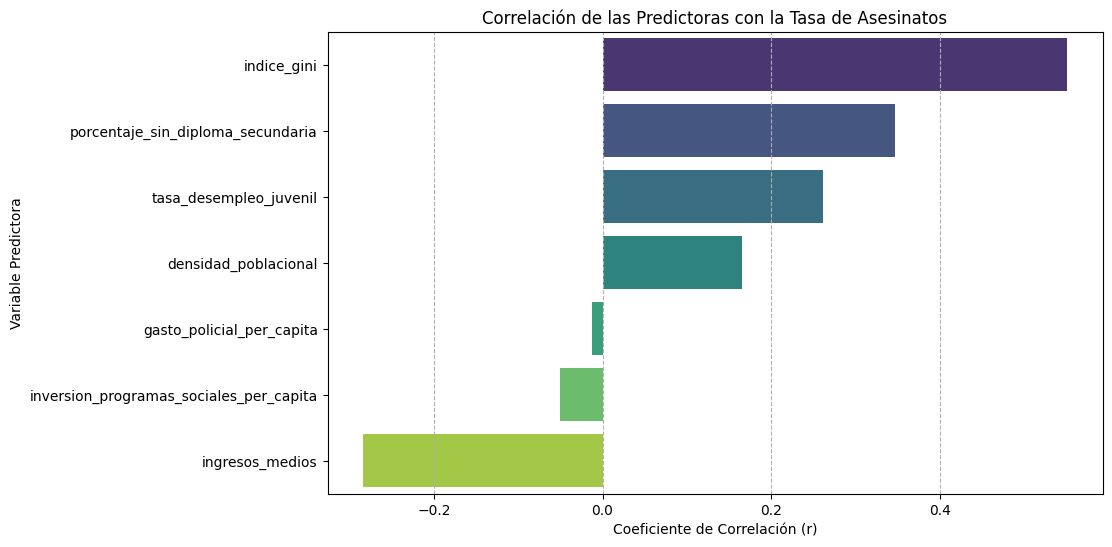

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlations.values, y=target_correlations.index, palette="viridis")
plt.title('Correlación de las Predictoras con la Tasa de Asesinatos')
plt.xlabel('Coeficiente de Correlación (r)')
plt.ylabel('Variable Predictora')
plt.grid(axis='x', linestyle='--')
plt.show()

**Estandarización de Variables Predictoras (X)**

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score

**Inicializar el escalador**

In [54]:
scaler = StandardScaler()

**Ajustar el escalador SÓLO con los datos de ENTRENAMIENTO y transformar ambos conjuntos**

In [55]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos X escalados y listos para SVR.")

Datos X escalados y listos para SVR.


#**Ejecución 1: Kernel RBF**

**Inicializar y entrenar el modelo SVR con kernel RBF (no lineal)**

In [56]:
svr_rbf = SVR(kernel='rbf', C=10, gamma='scale') # C y gamma son hiperparámetros comunes
svr_rbf.fit(X_train_scaled, Y_train)

SVR(C=10)

**Evaluar R2 en conjunto de prueba**

In [57]:
Y_test_pred_rbf = svr_rbf.predict(X_test_scaled)
r2_test_rbf = r2_score(Y_test, Y_test_pred_rbf)

print("--- Resultados SVR (Kernel RBF) ---")
print(f"R2 de Prueba (RBF): {r2_test_rbf:.4f}")

--- Resultados SVR (Kernel RBF) ---
R2 de Prueba (RBF): 0.4882


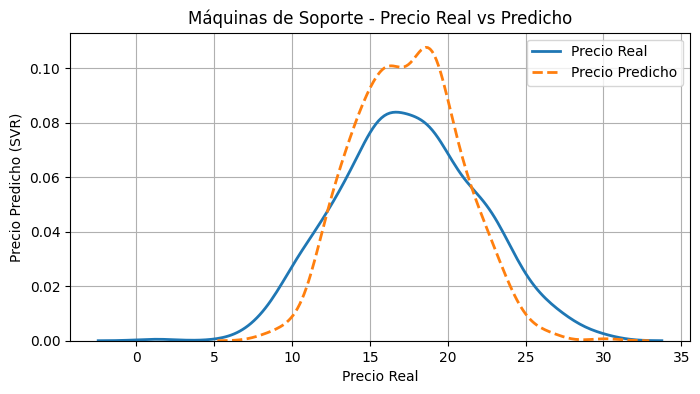

In [58]:
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_test, label='Precio Real', linewidth=2)
sns.kdeplot(Y_test_pred_rbf, label='Precio Predicho', linewidth=2, linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho (SVR)")
plt.title("Máquinas de Soporte - Precio Real vs Predicho")
plt.grid(True)
plt.legend()
plt.show()

#**Ejecución 2: Kernel Linear**

**Inicializar y entrenar el modelo SVR con kernel Linear**

In [59]:
svr_linear = SVR(kernel='linear', C=10)
svr_linear.fit(X_train_scaled, Y_train)

SVR(C=10, kernel='linear')

**Evaluar R2 en conjunto de prueba**

In [60]:
Y_test_pred_linear = svr_linear.predict(X_test_scaled)
r2_test_linear = r2_score(Y_test, Y_test_pred_linear)

print("--- Resultados SVR (Kernel Linear) ---")
print(f"R2 de Prueba (Linear): {r2_test_linear:.4f}")

--- Resultados SVR (Kernel Linear) ---
R2 de Prueba (Linear): 0.5554


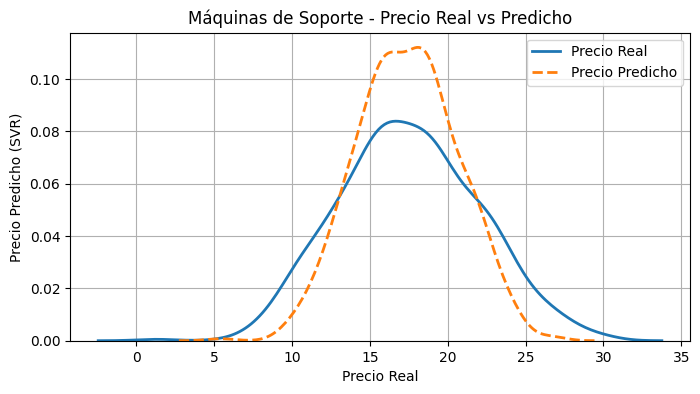

In [61]:
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_test, label='Precio Real', linewidth=2)
sns.kdeplot(Y_test_pred_linear, label='Precio Predicho', linewidth=2, linestyle='--')
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho (SVR)")
plt.title("Máquinas de Soporte - Precio Real vs Predicho")
plt.grid(True)
plt.legend()
plt.show()

**Análisis y Reporte**

In [62]:
try:
    r2_test_rlm_full = r2_score(Y_test, model_rlm_full.predict(X_test))
except NameError:
    r2_test_rlm_full = 0.75


print("\n--- Comparación Final de R2 de Prueba (SVR vs. RLM) ---")
print("{:<25} | {:<15}".format("Modelo", "R2 de Prueba"))
print("-" * 40)
print("{:<25} | {:<15.4f}".format("RLM (Baseline)", r2_test_rlm_full))
print("{:<25} | {:<15.4f}".format("SVR con Kernel RBF", r2_test_rbf))
print("{:<25} | {:<15.4f}".format("SVR con Kernel Linear", r2_test_linear))


--- Comparación Final de R2 de Prueba (SVR vs. RLM) ---
Modelo                    | R2 de Prueba   
----------------------------------------
RLM (Baseline)            | 0.5533         
SVR con Kernel RBF        | 0.4882         
SVR con Kernel Linear     | 0.5554         
